In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 31

**Author 1 (sciper):** Victor Dramé (xxxxx)  
**Author 2 (sciper):** Nicolas Feppon (249799)   
**Author 3 (sciper):** Nicolas Martinod (xxxxx)   

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
# import tarfile
import os

# data_base_path = os.path.join(os.pardir, 'data')
data_base_path = 'gdrive/My Drive/IAPR - TP/data/'
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

# tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
# with tarfile.open(tar_path, mode='r:gz') as tar:
#     tar.extractall(path=data_base_path)

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

#tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
#with tarfile.open(tar_path, mode='r:gz') as tar:
#    tar.extractall(path=data_base_path)

In [3]:
# Import necessary libraries

import numpy as np
import cv2
#import cv
from skimage.filters import threshold_otsu

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

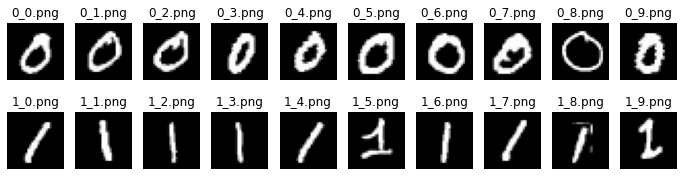

In [7]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

#### A. Implementation

 In order to extract 2 features from the Fourier descriptors, to represent the images, we go through the following steps:
 - We apply a high pass filter in order to enhance the contours, make them more sharp
 - We binarize the image 
 - We apply morphology to remove artifacts and to remove noise and high frequencies in the contours, just not on the zeros which are too thin ( corresponding to a small area )
 - We extract the contour with the biggest area to select the one corresponding to the outer contour in the zeros and to the numbers in the ones 
 - We calculate the fourier descriptors
 - We take only 2 features in the Fourier descriptors. Since we want invariance to rotation, scaling and translation, we choose to select the amplitude of the descriptors corresponding to the lowest frequencies, but not the lowest, since it is affected by translation. We calculate the amplitude for invariance to scaling. 
 - We plot the features extracted from the images in the 2D space of the features and verifiy that the classes are linearly separable.

# Rescaling and rotation

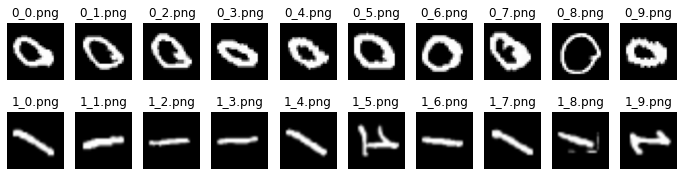

In [26]:
#  reload zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')

#percent by which the image is resized
z_scale = 1
o_scale = 2

#generate the new width and height
z_width = int(zeros_im.shape[2] * z_scale)
z_height = int(zeros_im.shape[1] * z_scale)
o_width = int(zeros_im.shape[2] * o_scale)
o_height = int(zeros_im.shape[1] * o_scale)

# dsize
z_dsize = (z_width, z_height)
o_dsize = (o_width, o_height)


#new resized array
z_im_resized=np.zeros((zeros_im.shape[0],z_width,z_height))
o_im_resized=np.zeros((ones_im.shape[0],o_width,o_height))

# resize image
for i,(z_im,o_im) in enumerate(zip(zeros_im,ones_im)):
    z_im_resized[i,:,:] = cv2.resize(z_im, z_dsize)
    o_im_resized[i,:,:] = cv2.resize(o_im, o_dsize)
    z_im_resized[i,:,:] = cv2.rotate(z_im_resized[i,:,:], cv2.cv2.ROTATE_90_CLOCKWISE)
    o_im_resized[i,:,:] = cv2.rotate(o_im_resized[i,:,:], cv2.cv2.ROTATE_90_CLOCKWISE)



    
z_im_resized=z_im_resized.astype(np.uint8)  
o_im_resized=o_im_resized.astype(np.uint8)


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], z_im_resized, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], o_im_resized, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)


In [27]:
zeros_im=z_im_resized
ones_im=o_im_resized

In [33]:
image_show_o = []
image_show_z = []
FD_zeros = np.zeros((len(zeros_im),2))
FD_ones = np.zeros((len(zeros_im),2))

for i, (z_im, o_im) in enumerate(zip(zeros_im, ones_im)):
    # High pass filtering for clearer contours
    HPfilt = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
    im_filt_z = cv2.filter2D(z_im, -1, HPfilt) 
    im_filt_o = cv2.filter2D(o_im, -1, HPfilt) 
    
    # Binarization
    thresh_z = threshold_otsu(im_filt_z)
    _, im_bin_z = cv2.threshold(im_filt_z, thresh_z, 255, cv2.THRESH_BINARY)
    thresh_o = threshold_otsu(im_filt_o)
    _, im_bin_o = cv2.threshold(im_filt_o, thresh_o, 255, cv2.THRESH_BINARY)
    
    # calculating the area of the zeros
    area_z = sum(sum(im_bin_z == 255))
    
    # Closing to remove artifacts
    k1 = np.ones((2,2))
    k2 = np.ones((2,1))
    im_close_z = cv2.morphologyEx(im_bin_z, cv2.MORPH_CLOSE, k1)
    im_close_o = cv2.morphologyEx(im_bin_o, cv2.MORPH_CLOSE, k1)
    
    # Opening to remove a bit of noise in the contours
    if area_z > 120: # do not open for the zero which is too thin
        im_morph_z = cv2.morphologyEx(im_close_z, cv2.MORPH_OPEN, k2)
    else : 
        im_morph_z = im_close_z
    im_morph_o = cv2.morphologyEx(im_close_o, cv2.MORPH_OPEN, k2)
    
    # find contours 
    cont_z, _ = cv2.findContours(im_morph_z, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cont_o, _ = cv2.findContours(im_morph_o, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    # select contour which has the biggest area
    main_contour_z = max(cont_z, key = lambda c: cv2.contourArea(c))
    main_contour_o = max(cont_o, key = lambda c: cv2.contourArea(c))
    
    # calculate Fourier descriptors from contour
    FD_z = cv2.ximgproc.fourierDescriptor(main_contour_z)
    FD_o = cv2.ximgproc.fourierDescriptor(main_contour_o)
    # we want invariance to rotation, scaling and translation, so we calculate the amplitudes of the second 
    # and third Fourier descriptors
    FD_zeros[i,:] = np.array([np.sqrt(FD_z[1,0,0]**2 + FD_z[1,0,1]**2), np.sqrt(FD_z[2,0,0]**2 + FD_z[2,0,1]**2)])
    FD_ones[i,:] = np.array([np.sqrt(FD_o[1,0,0]**2 + FD_o[1,0,1]**2), np.sqrt(FD_o[2,0,0]**2 + FD_o[2,0,1]**2)])
    
    # For plotting images
    image_show_z.append(im_morph_z)
    image_show_o.append(im_morph_o)

scale= 1 

FD_zeros_shape=(48, 1, 2) 

FD_zeros=

[[[ 1.48688030e+01  1.68156471e+01]]

 [[ 1.33817673e+00 -1.21160722e+00]]

 [[ 1.32296562e-01 -4.44655776e-01]]

 [[ 9.78659317e-02 -4.26534228e-02]]

 [[-3.87173072e-02  1.40765786e-01]]

 [[-6.80860206e-02  2.03672182e-02]]

[[-3.47780325e-02  4.44693081e-02]]

scale=2

FD_zeros_shape=(108, 1, 2) 

FD_zeros=

[[[ 2.96260071e+01  3.23093147e+01]]

 [[ 2.64383841e+00 -2.21643066e+00]]

 [[ 2.41860703e-01 -8.77316892e-01]]

 [[ 2.64634103e-01 -1.09954104e-01]]

 [[-1.21391214e-01  1.88196465e-01]]

 [[-1.97389990e-01  1.56919226e-01]]

scale=4

FD_zeros_shape=(216, 1, 2)

FD_zeros=

[[[ 5.88285294e+01  6.24100227e+01]]

 [[ 5.05986977e+00 -4.84873724e+00]]

 [[ 3.06050897e-01 -1.60905313e+00]]

 [[ 3.20996344e-01 -1.55566812e-01]]

 [[-1.98741585e-01  4.78615493e-01]]

 [[-3.54327738e-01  3.04415613e-01]]

 [[-1.59693584e-01  1.11131728e-01]]

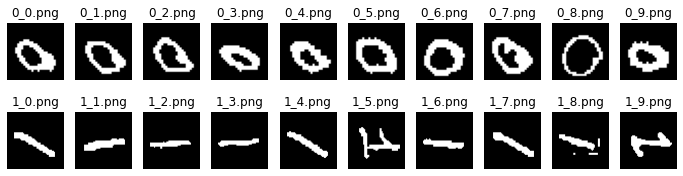

In [34]:
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], image_show_z, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], image_show_o, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

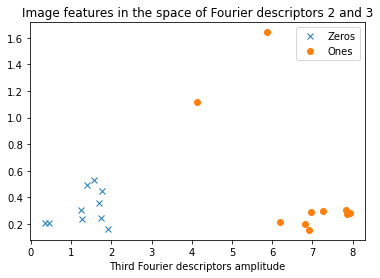

In [47]:
# Plotting the Fourier descriptor features in 2D space
plt.plot(FD_zeros[:,0], FD_zeros[:,1], 'x')
plt.plot(FD_ones[:,0], FD_ones[:,1], 'o')
plt.title('Image features in the space of Fourier descriptors 2 and 3')
plt.xlabel('Second Fourier descriptors amplitude')
plt.xlabel('Third Fourier descriptors amplitude')
plt.legend(['Zeros', 'Ones'])
plt.show()

We can see that the 2 features extracted enable us to linearly separate the 2 classes of images, the zeros and the ones. 

It SHOULD be invariant to scaling, rotation and translation, but I am not entirely sure about the scaling --> A verifier !

not invariant to scaling

### 1.3 Additional method (5 pts)

In [9]:
# Add your implementation and discussion

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

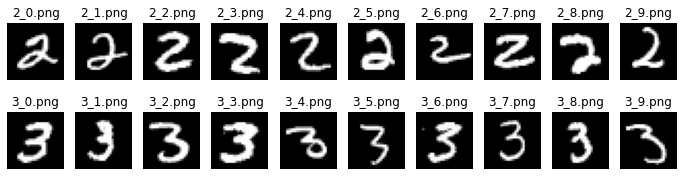

In [12]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In [43]:
image_show_2 = []
image_show_3 = []
FD_twos = np.zeros((len(twos_im),2))
FD_threes = np.zeros((len(threes_im),2))

for i, (two_im, three_im) in enumerate(zip(twos_im, threes_im)):
    # High pass filtering for clearer contours
    HPfilt = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
    im_filt_2 = cv2.filter2D(two_im, -1, HPfilt) 
    im_filt_3 = cv2.filter2D(three_im, -1, HPfilt) 
    
    # Binarization
    thresh_2 = threshold_otsu(im_filt_2)
    _, im_bin_2 = cv2.threshold(im_filt_2, thresh_2, 255, cv2.THRESH_BINARY)
    thresh_3 = threshold_otsu(im_filt_3)
    _, im_bin_3 = cv2.threshold(im_filt_3, thresh_3, 255, cv2.THRESH_BINARY)
    
    # Closing to remove artifacts
    k1 = np.ones((1,2))
    k2 = np.ones((1,2))
    im_close_2 = cv2.morphologyEx(im_bin_2, cv2.MORPH_CLOSE, k1)
    im_close_3 = cv2.morphologyEx(im_bin_3, cv2.MORPH_CLOSE, k1)
    
    # Opening to remove a bit of noise in the contours
    im_morph_2 = cv2.morphologyEx(im_close_2, cv2.MORPH_OPEN, k2)
    im_morph_3 = cv2.morphologyEx(im_close_3, cv2.MORPH_OPEN, k2)
    
    # find contours 
    cont_2, _ = cv2.findContours(im_morph_2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cont_3, _ = cv2.findContours(im_morph_3, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    # select contour which has the biggest area
    main_contour_2 = max(cont_2, key = lambda c: cv2.contourArea(c))
    main_contour_3 = max(cont_3, key = lambda c: cv2.contourArea(c))
    
    # calculate Fourier descriptors from contour
    FD_2 = cv2.ximgproc.fourierDescriptor(main_contour_2)
    FD_3 = cv2.ximgproc.fourierDescriptor(main_contour_3)
    # we want invariance to rotation, scaling and translation, so we calculate the amplitudes of the second 
    # and third Fourier descriptors
    FD_twos[i,:] = np.array([np.sqrt(FD_2[1,0,0]**2 + FD_2[1,0,1]**2), np.sqrt(FD_2[2,0,0]**2 + FD_2[2,0,1]**2)])
    FD_threes[i,:] = np.array([np.sqrt(FD_3[1,0,0]**2 + FD_3[1,0,1]**2), np.sqrt(FD_3[2,0,0]**2 + FD_3[2,0,1]**2)])
    
    # For plotting images
    image_show_2.append(im_morph_2)
    image_show_3.append(im_morph_3)

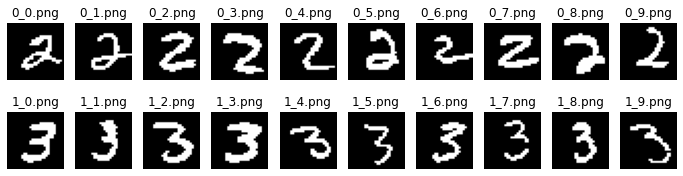

In [44]:
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], image_show_2, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], image_show_3, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

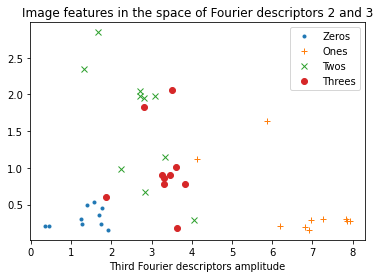

In [48]:
# Plotting the Fourier descriptor features in 2D space
plt.plot(FD_zeros[:,0], FD_zeros[:,1], '.')
plt.plot(FD_ones[:,0], FD_ones[:,1], '+')
plt.plot(FD_twos[:,0], FD_twos[:,1], 'x')
plt.plot(FD_threes[:,0], FD_threes[:,1], 'o')

plt.title('Image features in the space of Fourier descriptors 2 and 3')
plt.xlabel('Second Fourier descriptors amplitude')
plt.xlabel('Third Fourier descriptors amplitude')
plt.legend(['Zeros', 'Ones','Twos','Threes'])
plt.show()

It won't be possible to classify all this digit with a single 2D vector but we could use four 2D vector with a logic of one versus all. This should works but we can see that we have some noise on the twos and threes. 

->peut etre check d'autre fourier coef
->regarder pour l'invariance aussi 